In [26]:
import numpy as np
import pandas as pd
from mesa import batch_run
import matplotlib.pyplot as plt
from model import SugarscapeG1mt

In [27]:
def gini(x):
    """
    Compute Gini Coefficient

    Parameters:
    x : numpy.ndarray
        A one dimensional array of non negative numbers.
        Each element represents an individual's amount of income.

    Returns:
    float 
        Gini coefficient 
    """
    x = x.astype(float)
    if x.sum() == 0:
        return 0.0
    x_sorted = np.sort(x)
    n        = x_sorted.size
    cumx     = np.cumsum(x_sorted, dtype=float)
    
    return (n + 1 - 2 * (cumx / cumx[-1]).sum()) / n

In [28]:
"""
Run model
"""
model = SugarscapeG1mt()
for _ in range(100):
    model.step()

c:\Users\TWTNi\OneDrive\CompScience\abm\ABM\model.py:27: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
c:\Users\TWTNi\.virtualenvs\ABM-Notebooks-0-1-FIYP4_Qh\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Sampled visions: [4 3 3 3 4 5 2 2 1 3]
Index(['#Traders', 'Trade Volume', 'Price', 'Sugar Treasury', 'Spice Treasury',
       'Wealth Treasury'],
      dtype='object')


In [ ]:
# DATA PREPERATION
# reset_index() turns the multi index into regular columns
agent_df = model.datacollector.get_agent_vars_dataframe().reset_index()
# Wealth formula (open for discussion)
agent_df['Wealth'] = agent_df['sugar'] + agent_df['spice']  
# Gather the array of all agents at each timestep and make it a numpy array
wealth_by_step = agent_df.groupby('Step')['Wealth'].apply(np.array)

# -----------------------------------------------------------------------------------------------#

# GINI TIME SERIES
# Obtain all agent's wealth at each timestep and compute gini coefficient with predefined function
gini_series = wealth_by_step.apply(gini) 

# -----------------------------------------------------------------------------------------------#

# LORENZ CURVE
# Obtain final wealth from each agent
final_wealth = wealth_by_step.iloc[-1]
# Obaint final number of agents
n            = final_wealth.size
# Sort agents by wealth, poor to rich
sorted_w     = np.sort(final_wealth)
# Divide individuals cummulative wealth by total wealth and at starting point 0,0
cum_income   = np.insert(np.cumsum(sorted_w) / sorted_w.sum(), 0, 0)
# Evenly spaced values
cum_pop      = np.linspace(0, 1, n + 1)


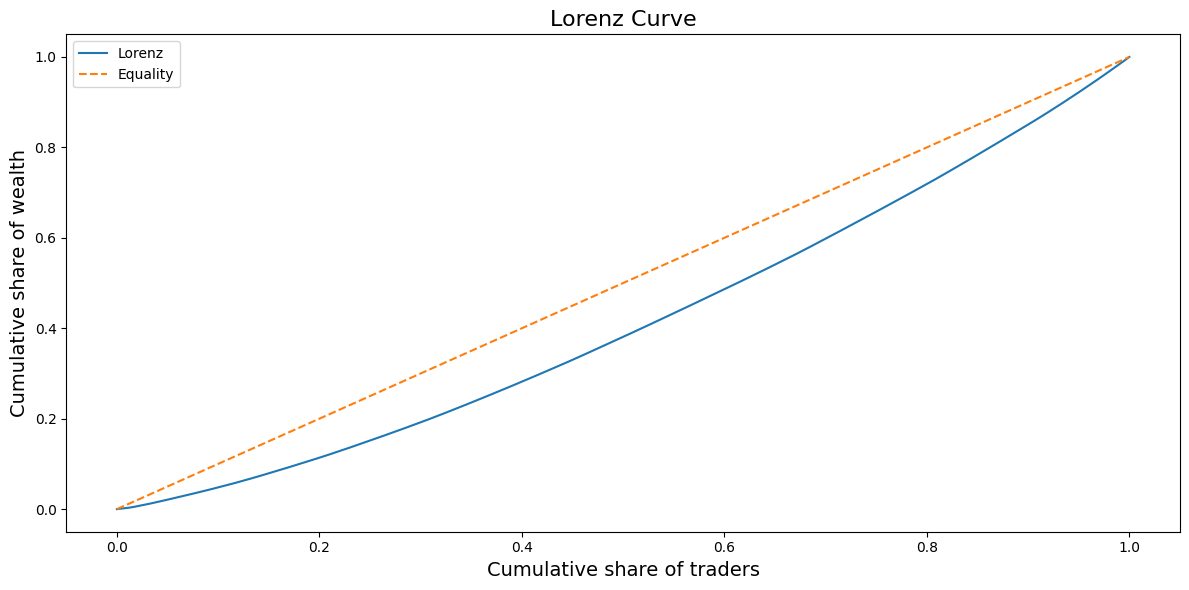

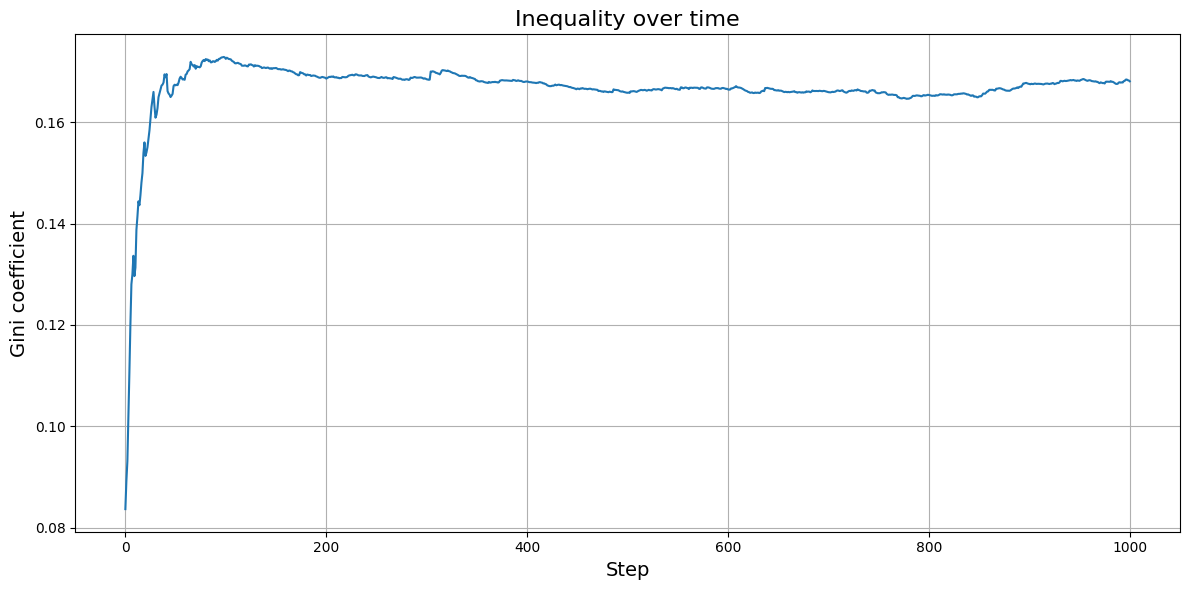

In [25]:
# --- Lorenz Curve --- #
plt.figure(figsize=(12,6))
plt.plot(cum_pop, cum_income, label='Lorenz')
plt.plot([0,1],[0,1], linestyle='--', label='Equality')
plt.title("Lorenz Curve", fontsize=16)
plt.xlabel('Cumulative share of traders', fontsize=14)
plt.ylabel('Cumulative share of wealth', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# --- Gini coefficient timeseries --- #
plt.figure(figsize=(12,6))
plt.plot(gini_series.index, gini_series.values)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Gini coefficient", fontsize=14)
plt.title("Inequality over time", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()